In [1]:
'''
Get resources
'''
import sys
sys.path.insert(1,"/Users/admin/Desktop/jasmine/lakes21_parquet/Eco_KGML_workshop")

import os
if os.path.exists("/Users/admin/Desktop/jasmine/lakes21_parquet/Eco_KGML_workshop"):
  print("Directory already exists.")
else:
  os.system("git clone https://github.com/sepidehfat/Eco_KGML_workshop.git")
  print("Repository cloned.")


Directory already exists.


In [2]:
'''
Import necessary modules
'''
import random
import pandas as pd
import numpy as np
from tqdm import trange
import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from utils import  run_all, Utils
from encoder_decoder import seq2seq

import warnings
warnings.filterwarnings('ignore')

In [3]:
'''
Set up environment - Running on GPU if available
'''
if torch.cuda.is_available():
    device=torch.device("cuda")
    print('Computational device:GPU')

else:
    device=torch.device('cpu')
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under Runtime -> "
        "Change runtime type. select GPU.")

In [4]:
'''
Set up environment - Handles variabilty and remain reproducible by controlling sources of randomness through setting seed values
'''
seed = 2024
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
'''
Define some hyperparameters required for learning
'''
#Type of the model
model_type='LSTM'

#Output size of our encoder_decoder model(Number of target variable)
output_size=1

#Number of layers in our deep learning model
num_layer=1

#Hidden cell size
hidden_feature_size=64

#Dropout is a form of regularization
dropout = 0.05

#Whether we want to shuffle the batches while generating the training batches
batch_shuffle = True

#Frequency of evaluation --> if iteration_num % eval_freq ==0 --> then perform evaluation
eval_freq = 1 

'''
Learning rate scheduler parameters
'''
max_lr=5e-4
div_factor=100
pct_start=0.05
anneal_strategy='cos'
final_div_factor=10000.0

'''
Parameters for early stopping
'''
#If there is no imrovement for a 'thres' number of epochs, stop the training process
early_stop = False

#Quantifying the improvement. If the loss is greater than min_val_loss_so_far + delta for thres number of iterations, stop the training
thres=5

#Specifying the percentage of times we want to enforce teacher forcing
delta=0.5
teacher_forcing_ratio = 0.0
training_prediction = 'recursive'


In [6]:
'''
Read the file with Lake Mendota's data
'''
file_name='lake_me_year.csv'
me_df=pd.read_csv(file_name)
me_df=me_df[(me_df['year']==2019) | (me_df['year']==2020)]

'''
Retaining every fourth row to decrease dataset to 1/4 of its original size and thus increase sparsity
'''
me_df=me_df[::4]

me_df=me_df.sort_values(by=['date','time'])
me_df

'''
An Adjustment on datetimes that include time at 12:00 am
'''
def add_missing_time(datetime):
    if len(datetime)==10:
        return datetime+ ' 00:00:00'
    return datetime

me_df['datetime']=me_df['datetime'].apply(add_missing_time)
me_df

,datetime,lake_id,date,time,do,temp,tp,tn,do_lf,secchi,year
9060,2019-04-16 14:00:00,ME,2019-04-16,14:00:00,15.21,6.09,67.231876,1950.351190,15.166369,1.840774,2019
9064,2019-04-16 18:00:00,ME,2019-04-16,18:00:00,16.19,5.82,66.315632,1950.755952,15.181845,1.853869,2019
9068,2019-04-16 22:00:00,ME,2019-04-16,22:00:00,14.75,4.65,65.399388,1951.160714,15.197321,1.866964,2019
9072,2019-04-17 02:00:00,ME,2019-04-17,02:00:00,14.12,4.36,64.483144,1951.565476,15.212798,1.880060,2019
9076,2019-04-17 06:00:00,ME,2019-04-17,06:00:00,13.72,4.15,63.566900,1951.970238,15.228274,1.893155,2019
...,...,...,...,...,...,...,...,...,...,...,...
18528,2020-11-20 14:00:00,ME,2020-11-20,14:00:00,10.94,7.71,0.105676,1420.135135,12.281982,5.274775,2020
18532,2020-11-20 18:00:00,ME,2020-11-20,18:00:00,10.92,7.65,0.105757,1421.351351,12.286486,5.281081,2020
18536,2020-11-20 22:00:00,ME,2020-11-20,22:00:00,10.92,7.64,0.105838,1422.567568,12.290991,5.287387,2020
18540,2020-11-21 02:00:00,ME,2020-11-21,02:00:00,10.91,7.64,0.105919,1423.783784,12.295495,5.293694,2020


In [7]:
'''
Filter specific columns from me_df for training
'''
me_df_training=me_df.loc[:,["datetime","date","time","do","temp","tp","tn","do_lf","secchi"]]
me_df_training.columns

Index(['datetime', 'date', 'time', 'do', 'temp', 'tp', 'tn', 'do_lf',
       'secchi'],
      dtype='object')

In [8]:
'''
Define columns(features, date, target) for learning
'''
feature_cols=['temp','tp','tn','do_lf','secchi']
date_col=['datetime','date','time']
target_col=['do']

In [9]:
'''
Create a utility object
'''
utils = Utils(num_features=len(feature_cols), inp_cols=feature_cols, target_cols=target_col, date_col=date_col, num_out_features=output_size, device=device)

In [10]:
'''
Split train/test data
'''
split_ratio=0.6
df_train,df_test=utils.train_test_split(me_df_training,split_ratio=split_ratio)
df_train

,datetime,date,time,do,temp,tp,tn,do_lf,secchi
0,2019-04-16 14:00:00,2019-04-16,14:00:00,15.21,6.09,67.231876,1950.351190,15.166369,1.840774
1,2019-04-16 18:00:00,2019-04-16,18:00:00,16.19,5.82,66.315632,1950.755952,15.181845,1.853869
2,2019-04-16 22:00:00,2019-04-16,22:00:00,14.75,4.65,65.399388,1951.160714,15.197321,1.866964
3,2019-04-17 02:00:00,2019-04-17,02:00:00,14.12,4.36,64.483144,1951.565476,15.212798,1.880060
4,2019-04-17 06:00:00,2019-04-17,06:00:00,13.72,4.15,63.566900,1951.970238,15.228274,1.893155
...,...,...,...,...,...,...,...,...,...
1418,2020-06-11 08:00:00,2020-06-11,08:00:00,8.71,19.48,0.091633,1611.833333,10.022917,7.228333
1419,2020-06-11 12:00:00,2020-06-11,12:00:00,8.85,19.85,0.091767,1611.166667,10.014583,7.181667
1420,2020-06-11 16:00:00,2020-06-11,16:00:00,8.89,19.86,0.091900,1610.500000,10.006250,7.135000
1421,2020-06-11 20:00:00,2020-06-11,20:00:00,8.89,19.83,0.091851,1607.152778,10.009028,7.085764


In [11]:
'''
Normalize the data
'''
df_train=utils.normalize(df_train)
df_test=utils.normalize(df_test,use_stat=True)
df_test

,datetime,date,time,do,temp,tp,tn,do_lf,secchi
0,2020-06-12 04:00:00,2020-06-12,04:00:00,-0.658968,0.503830,-0.493924,0.141248,-0.832338,1.218351
1,2020-06-12 08:00:00,2020-06-12,08:00:00,-0.655500,0.506636,-0.493961,0.111337,-0.818975,1.195595
2,2020-06-12 12:00:00,2020-06-12,12:00:00,-0.627753,0.820979,-0.493998,0.081426,-0.805612,1.172838
3,2020-06-12 16:00:00,2020-06-12,16:00:00,-0.530640,0.717134,-0.494035,0.051515,-0.792250,1.150082
4,2020-06-12 20:00:00,2020-06-12,20:00:00,-0.589601,0.596449,-0.494072,0.021604,-0.778887,1.127325
...,...,...,...,...,...,...,...,...,...
944,2020-11-20 14:00:00,2020-11-20,14:00:00,0.121406,-1.168923,-0.492994,-0.290101,-0.017975,0.540145
945,2020-11-20 18:00:00,2020-11-20,18:00:00,0.114470,-1.177343,-0.492989,-0.286906,-0.016308,0.542666
946,2020-11-20 22:00:00,2020-11-20,22:00:00,0.114470,-1.178746,-0.492984,-0.283712,-0.014641,0.545186
947,2020-11-21 02:00:00,2020-11-21,02:00:00,0.111001,-1.178746,-0.492979,-0.280518,-0.012974,0.547706


In [12]:

'''
Generating Lake Mendota's data samples
'''
#Lookback window
input_window=4

#Horizon window
output_window=2

#Define the number of stride the sliding window need to take  while creating each sample(lookback window + horizon window= 1 sample)
stride=1

#Create samples: 1 sample = lookback window + horizon window
x_train,y_train=utils.windowed_dataset(df_train,input_window,output_window,stride)
x_test,y_test=utils.windowed_dataset(df_test,input_window,output_window,stride)

In [13]:
'''
Modeling - Define hyperparameters for model training
'''
#Batch size during training
batch_size=32

#Number of epochs(1 epoch = 1 pass of the complete training data through the model)
epochs=100

#Learning rate specifies the rate where we want to update the model parameters after every training pass
learning_rate=0.0001

#Specify the amount of L2 regularization to be applied
weight_decay=0.05


In [14]:
'''
Define config file
'''
config={
    "batch_size":batch_size,
    "epochs":epochs,
    "learning_rate":learning_rate,
    "eval_freq":eval_freq,
    "batch_shuffle":batch_shuffle,
    "dropout":dropout,
    "num_layers":num_layer,
    "hidden_feature_size":hidden_feature_size,
    "model_type":model_type,
    "teacher_forcing_ratio":teacher_forcing_ratio,
    "max_lr":max_lr,
    "div_factor":div_factor,
    "pct_start":pct_start,
    "anneal_strategy":anneal_strategy,
    "final_div_factor":final_div_factor,
    "dataset":file_name,
    "split_ratio":split_ratio,
    "input_window":input_window,
    "output_window":output_window,
    "early_stop_thres":thres,
    "early_stop_delta":delta,
    "early_stop":early_stop,
    "weight_decay":weight_decay
}

In [15]:
'''
Create the seq2seq model
'''
model=seq2seq(input_size=x_train.shape[2],
              hidden_size=hidden_feature_size,
              output_size=output_size,
              model_type=model_type,
              num_layers=num_layer,
              utils=utils,
              dropout=dropout,
              device=device
              )

In [16]:
'''
Train the model
'''
loss,test_rmse,train_rmse=model.train_model(x_train,y_train,x_test,y_test,
                                            target_len=output_window,
                                            config=config,
                                            training_prediction=training_prediction)

100%|██████████| 100/100 [00:31<00:00,  3.20it/s, loss=0.167, test_rmse=2.31, train_rmse=1.18]


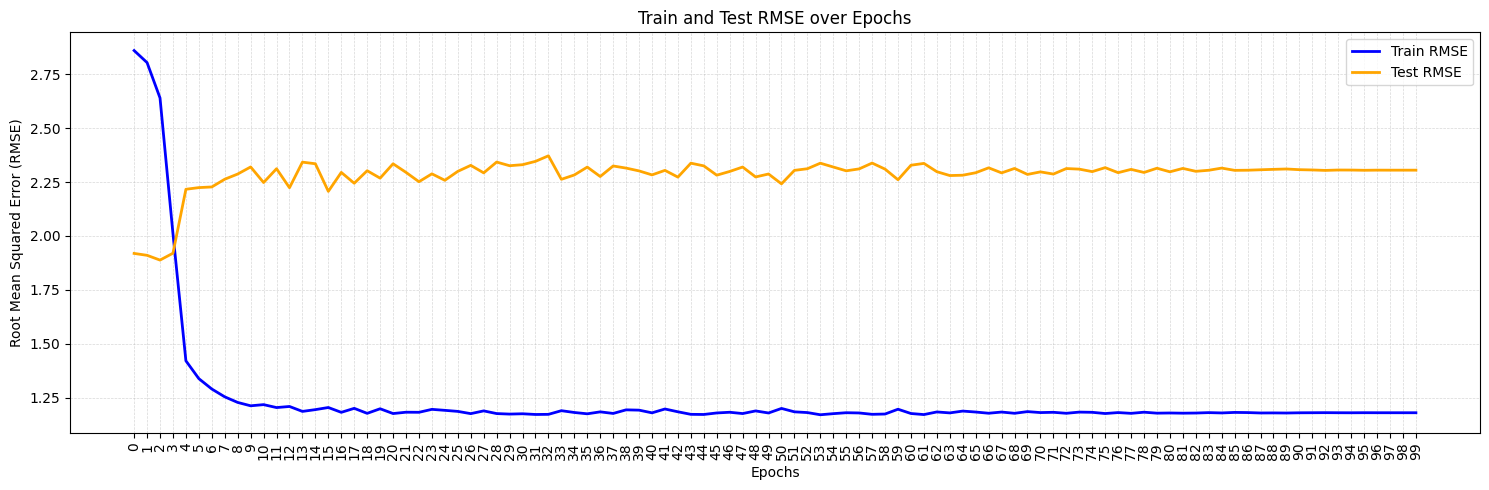

In [17]:
'''
Plot train-test Root Mean Squared Error(RMSE)
'''
utils.plot_RMSE_epochs(test_rmse,train_rmse)

In [18]:
'''
Evaluation - Perform Evaluation
'''
train_eval_metrics=model.evaluate_batch(x_train.to(device),y_train.to(device))
test_eval_metrics=model.evaluate_batch(x_test.to(device),y_test.to(device))

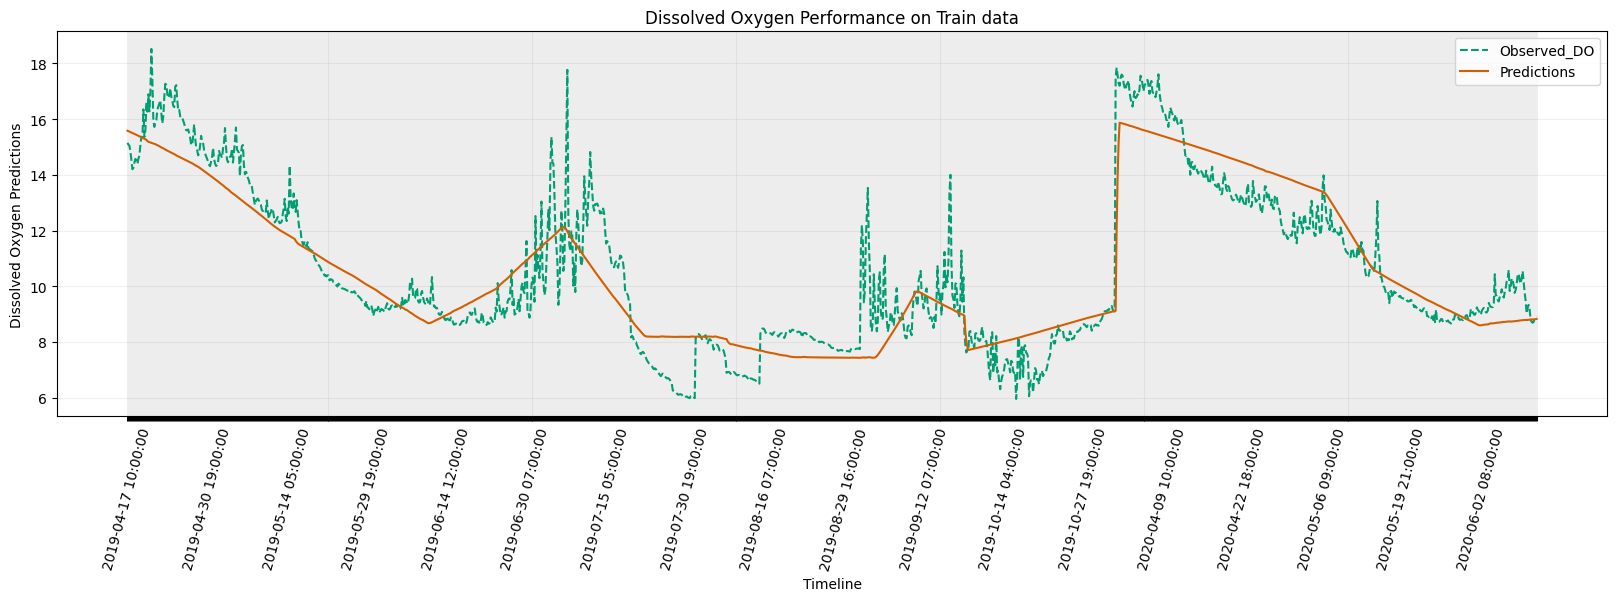

,T+str(t)
2019-04-17 10:00:00,15.584904
2019-04-17 14:00:00,15.567484
2019-04-17 18:00:00,15.550352
2019-04-17 22:00:00,15.533701
2019-04-18 02:00:00,15.516907
...,...
2020-06-11 04:00:00,8.807646
2020-06-11 08:00:00,8.809509
2020-06-11 12:00:00,8.812405
2020-06-11 16:00:00,8.817060


In [19]:
'''
Visualization - Generate the plots on train data
'''
horizon_range=[1] #Specify the list of T+n prediction to plot
plot_df_train=utils.plot_predictions(df_train,train_eval_metrics,horizon_range,split='Train')
# this will plot T+1 predictions and Ground Observed Dissolved Oxygen and create a dataset(Timeline as tag and T+1 predictions as a column) for plotting in R later
plot_df_train

In [20]:
'''
Convert the tag(Timeline) to a column and rename it
'''
plot_df_train=plot_df_train.reset_index()
plot_df_train.rename(columns={'index':'datetime'},inplace=True)

In [21]:
'''
Merge plot_df_train(the dataset with predictions) with actual observations
'''
merged_df_train=pd.merge(plot_df_train,me_df,on='datetime',how='left')
merged_df_train

,datetime,T+str(t),lake_id,date,time,do,temp,tp,tn,do_lf,secchi,year
0,2019-04-17 10:00:00,15.584904,ME,2019-04-17,10:00:00,15.15,4.67,62.650656,1952.375000,15.243750,1.906250,2019
1,2019-04-17 14:00:00,15.567484,ME,2019-04-17,14:00:00,15.08,4.63,61.734412,1952.779762,15.259226,1.919345,2019
2,2019-04-17 18:00:00,15.550352,ME,2019-04-17,18:00:00,15.04,4.58,60.818168,1953.184524,15.274702,1.932440,2019
3,2019-04-17 22:00:00,15.533701,ME,2019-04-17,22:00:00,14.82,4.63,59.901924,1953.589286,15.290179,1.945536,2019
4,2019-04-18 02:00:00,15.516907,ME,2019-04-18,02:00:00,14.52,4.50,58.985680,1953.994048,15.305655,1.958631,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,2020-06-11 04:00:00,8.807646,ME,2020-06-11,04:00:00,8.69,19.53,0.091500,1612.500000,10.031250,7.275000,2020
1413,2020-06-11 08:00:00,8.809509,ME,2020-06-11,08:00:00,8.71,19.48,0.091633,1611.833333,10.022917,7.228333,2020
1414,2020-06-11 12:00:00,8.812405,ME,2020-06-11,12:00:00,8.85,19.85,0.091767,1611.166667,10.014583,7.181667,2020
1415,2020-06-11 16:00:00,8.817060,ME,2020-06-11,16:00:00,8.89,19.86,0.091900,1610.500000,10.006250,7.135000,2020


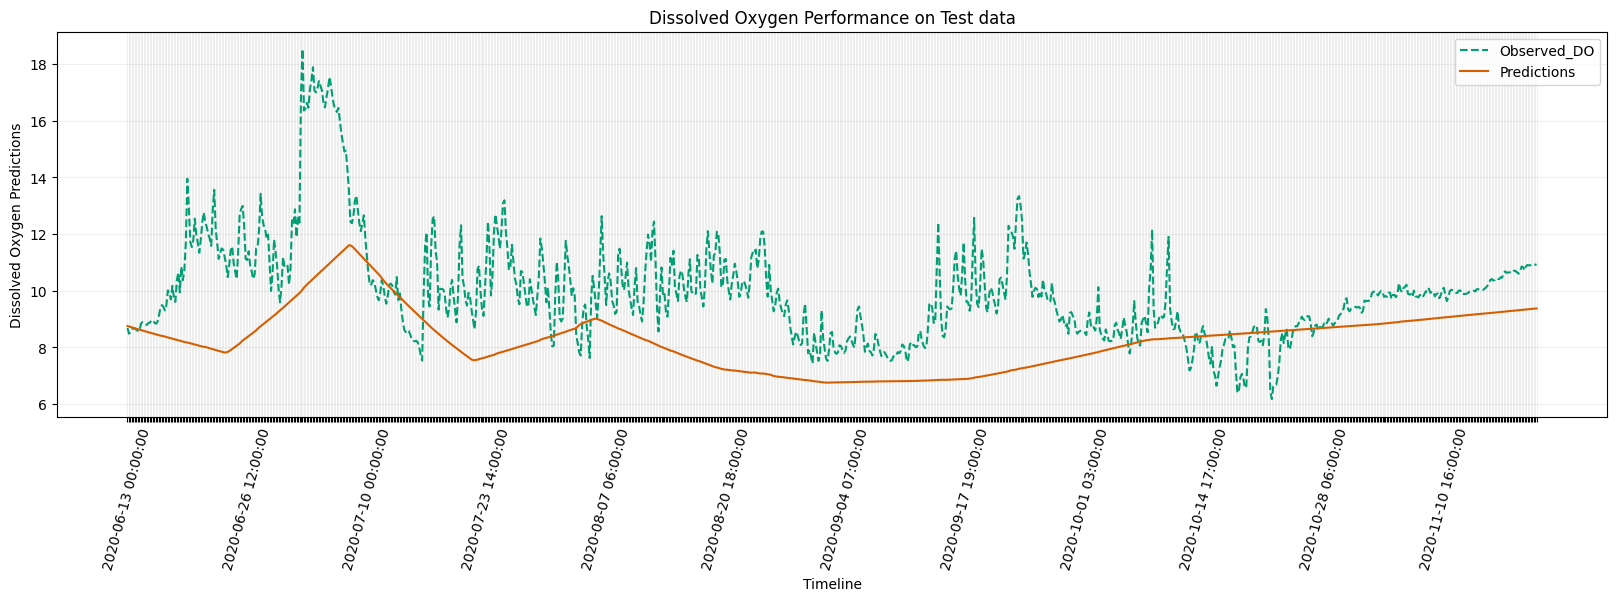

In [22]:
'''
Visualization - Generate the plots on test data
'''
horizon_range=[1]  #Specify the list of T+n predictions to plot
plot_df_test=utils.plot_predictions(df_test,test_eval_metrics,horizon_range,split='Test') 
# this will plot T+1 predictions and Ground Observed Dissolved Oxygen and create a dataset(Timeline as label and T+1 predictions as one column)

In [23]:
'''
Convert the tag (Timeline) to a column and rename it
'''
plot_df_test=plot_df_test.reset_index()
plot_df_test.rename(columns={'index':'datetime'},inplace=True)

In [24]:
'''
Merge plot_df_test(the dataset with predictions) with actual observations
'''
merged_df_test=pd.merge(plot_df_test,me_df,on='datetime',how='left')
merged_df_test

,datetime,T+str(t),lake_id,date,time,do,temp,tp,tn,do_lf,secchi,year
0,2020-06-13 00:00:00,8.751606,ME,2020-06-13,00:00:00,8.68,20.13,0.087670,1527.430556,10.261806,6.687153,2020
1,2020-06-13 04:00:00,8.734608,ME,2020-06-13,04:00:00,8.48,19.59,0.087073,1516.041667,10.297917,6.630208,2020
2,2020-06-13 08:00:00,8.716190,ME,2020-06-13,08:00:00,8.53,19.48,0.086476,1504.652778,10.334028,6.573264,2020
3,2020-06-13 12:00:00,8.699065,ME,2020-06-13,12:00:00,8.63,19.66,0.085878,1493.263889,10.370139,6.516319,2020
4,2020-06-13 16:00:00,8.683574,ME,2020-06-13,16:00:00,8.67,19.97,0.085281,1481.875000,10.406250,6.459375,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
938,2020-11-20 10:00:00,9.349504,ME,2020-11-20,10:00:00,10.90,7.66,0.105595,1418.918919,12.277477,5.268468,2020
939,2020-11-20 14:00:00,9.354939,ME,2020-11-20,14:00:00,10.94,7.71,0.105676,1420.135135,12.281982,5.274775,2020
940,2020-11-20 18:00:00,9.360506,ME,2020-11-20,18:00:00,10.92,7.65,0.105757,1421.351351,12.286486,5.281081,2020
941,2020-11-20 22:00:00,9.365887,ME,2020-11-20,22:00:00,10.92,7.64,0.105838,1422.567568,12.290991,5.287387,2020


In [25]:
'''
Save merged datasets as csv files for further analysis and plotting
'''
merged_df_train.to_csv('/Users/admin/Desktop/jasmine/ Outcomes/merged_df_train.csv',index=False)
merged_df_test.to_csv('/Users/admin/Desktop/jasmine/ Outcomes/merged_df_test.csv',index=False)